This notebook takes an excel table of palaeomagnetic data and makes a space-time plot to depict the quality and uncertainty of said data.  In this case, the palaeomagnetic table is what was used in Merdith et al. (2017).  The bare minimum to recreate the plot is (for each pole) an age range, inclination data (or palaeolatitude if already converted) and a95 confidence.  The table provided below is (more) complete than this.  Having a separate column for colourkey for plotting is useful, but not necessary.

References

Merdith, A.S., Collins, A.S., Williams, S.E., Pisarevsky, S., Foden, J.D., Archibald, D.B., Blades, M.L., Alessio, B.L., Armistead, S., Plavsa, D., Clark, C., and Müller, R.D. 2017. A full-plate global reconstruction of the Neoproterozoic. Gondwana Research, 50, pp.84-134.

In [1]:
import numpy as np
import math
import pandas as pd
import pygplates
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#load data
basedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/General_plate_reconstruction/Sample_data/'
df = pd.read_excel('%sNeoprot-poles.xlsx' % basedir)

#print out first few rows to check
df[:5]

,colourkey,Key,Craton,Rockunit,OldAge,YoungAge,Slat,Slong,Plat,Plong,A95,Reference,Q-factor,Declination,Inclination
0,Laurentia,L1,Laurentia,Gunbarrel Intrusions combined,780,776,45.00,-110.0,14.6,127.0,3.2,"Harlan et al., 2008",1110111 (6),301.500000,-17.100000
1,Laurentia,L2,Laurentia,Uinta Formation,800,750,41.00,-110.0,0.8,161.3,4.7,"Weil et al., 2006",0110111 (5),190.222222,-4.966667
2,Laurentia,L3,Laurentia,Kwagunt Formation,748,736,36.15,-112.0,18.2,166.0,7.0,"Weil et al., 2004",1111111 (7),280.800000,30.600000
3,Laurentia,L4,Laurentia,Franklin Dykes,727,712,75.00,-82.0,8.4,163.8,2.8,"Denyszyn et al., 2009",1111111 (7),117.425000,68.333000
4,Laurentia,L5,Laurentia,Long Range Dykes,617,613,53.50,-57.5,-19.0,175.3,17.4,"Murthy et al., 1992; Hodych et al., 2004;Age: ...",1011111 (6),110.300000,56.800000


In [3]:
#we want to get palaeolatitude, which comes from inclination data from the equation:
#Tan I = 2 tan λ
#where I is the inclination, and λ is the latitude (i.e. arctan of tan of half the inclination)

#have to do some odious conversions between rads, degrees etc.
palaeolatitude = [] 
for i in df['Inclination']:    
    palaeolatitude.append(np.rad2deg(np.arctan(np.tan(np.deg2rad(i))/2)))

In [4]:
#we want error bars on our plot to show the uncertainty
#a95 error for the y-axis, age error for the x-axis
#i think strictly a95 is circular while the actual confidence is eliptical (dp and dm)
#but a95 is more common in publications

#we also want colourkeys for plotting

age_error = []
age_average = []
a95_error = []
colourkeys = []

for i,j in zip(df['OldAge'],df['YoungAge']):
    age_error.append((i+j)/2 - j)
    age_average.append((i+j)/2)

for k in df['A95']:
    a95_error.append(k/2)

for j in df['colourkey']:
    colourkeys.append(str(j))

In [8]:
#i like viridis, so we generate a regular spaced RGB tuple for the number of unique colours we are plotting by
#(I am colouring poles by the continents they fall on)
#so colourkeys are our continents, and colours are the corresponding RGB tuple

unique_colourkeys = np.unique(colourkeys)
viridis = cm.get_cmap('viridis', len(unique_colourkeys))

#print out our colours
for i,j in zip(viridis.colors, unique_colourkeys):
    print i,j
    
#now we want to make them a dictionary for ease of plotting
colour_dict = dict(zip(unique_colourkeys, viridis.colors))

[0.267004 0.004874 0.329415 1.      ] Australia
[0.283072 0.130895 0.449241 1.      ] Baltica
[0.262138 0.242286 0.520837 1.      ] Congo
[0.220057 0.343307 0.549413 1.      ] India
[0.177423 0.437527 0.557565 1.      ] Laurentia
[0.143343 0.522773 0.556295 1.      ] North China
[0.119512 0.607464 0.540218 1.      ] Rio de la Plata
[0.166383 0.690856 0.496502 1.      ] Sao Francisco
[0.319809 0.770914 0.411152 1.      ] Seychelles
[0.525776 0.833491 0.288127 1.      ] Siberia
[0.762373 0.876424 0.137064 1.      ] South China
[0.993248 0.906157 0.143936 1.      ] Tarim


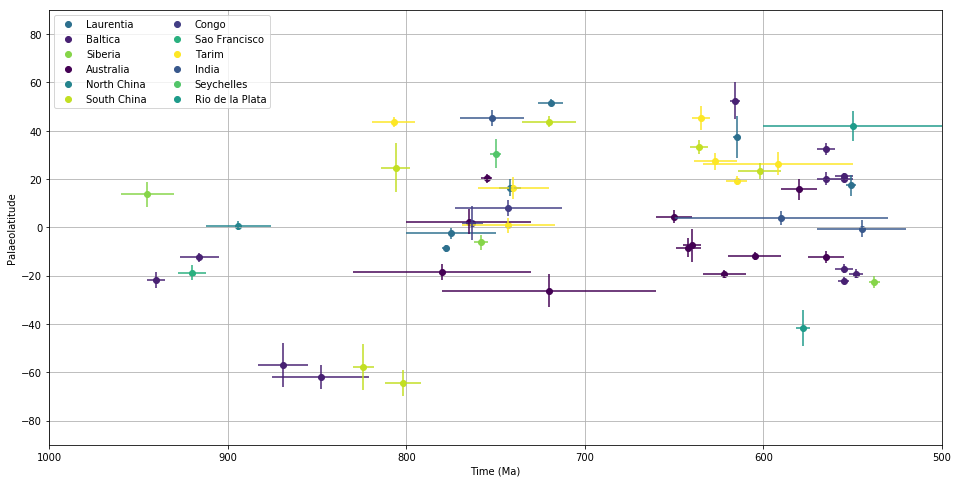

In [13]:
#yer i honestly can't believe i figured out how to plot this
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

#plot the centre circles first
#we enumerate through them to generate the proper label class
#(i.e. it should work in a single line but i can't figure it out :/)
for i, u in enumerate(colourkeys):
    xi = age_average[i]
    yi = palaeolatitude[i]
    ax.scatter(xi, yi, 
               c=[colour_dict[u]], 
               label=str(u))

#now the error bars, no labels, so a one line wonder
ax.errorbar(age_average, 
            palaeolatitude, 
            yerr=a95_error, 
            xerr=age_error, 
            color=[colour_dict[i] for i in colourkeys], 
            ls='none')

#the labels for the legend are a problem since we generate duplicates
#this gets unique labels from the plot data and plots them just once
#and was stolen from: https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), 
          by_label.keys(),
          loc='upper left', ncol=2)

ax.set_xlim(1000,500)
ax.set_ylim(-90,90)
ax.set_xlabel('Time (Ma)')
ax.set_ylabel('Palaeolatitude')
ax.grid()